In [1]:
%load_ext autoreload
%autoreload 2


In [3]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor

In [4]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "shared1000")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119.h5")
data = load_from_hdf5(data_path)
# subjects: ['paul_20241119', 'paul_241119']
subject_id = 'paul_20241119'
data_dict = load_neural_data(data_path, subject_id=subject_id, stimroot=stimroot)
trials_stim_names, rspavg_resp_peak, resp_tensor, trial_counters = load_neural_trial_resp_tensor(data_path, subject_id)

Trials shape: (1871,) (1871, 64)
Rspavg shape: (1028,) (1028, 64)
Response tensor shape (stimulus x neuron x trial): (1028, 64, 2)
Response tensor shape: (1028, 64, 2)
Trial counters shape: (1028,)
min and max trial counters: 1 2


In [5]:
def load_model_transform(modelname, device="cuda"):
    # Prepare model and transforms
    if modelname == "resnet50_robust":
        model = resnet50(pretrained=False)
        model.load_state_dict(th.load("/n/home12/binxuwang/Github/Closed-loop-visual-insilico/checkpoints/imagenet_linf_8_pure.pt"))
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50":
        model = resnet50(pretrained=True)
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50_clip":
        import clip
        model_clip, preprocess = clip.load('RN50', device=device)
        model = model_clip.visual
        transforms_pipeline = preprocess
    elif modelname == "resnet50_dino":
        # https://github.com/facebookresearch/dino
        model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        raise ValueError(f"Unknown model: {modelname}")
        # model = timm.create_model(modelname, pretrained=True).to(device).eval()
        # data_config = timm.data.resolve_model_data_config(model)
        # transforms_pipeline = timm.data.create_transform(**data_config, is_training=False)
    model = model.to(device).eval()
    model.requires_grad_(False)
    
    return model, transforms_pipeline

In [ ]:
# def extract_features(model, dataset, layer_name="last_block", batch_size=20, device="cuda"):
#     """Extract features from a specified layer of the model."""
#     fetcher = featureFetcher_module()
#     fetcher.record_module(model.layer4, layer_name, ) # this is for ResNet50, specifically, modify as needed
#     feat_dict = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
#     fetcher.cleanup()
#     del fetcher
#     return feat_dict

from sklearn.model_selection import train_test_split, GridSearchCV
def compute_D2_per_unit(rspavg_resp_peak, rspavg_pred):
    return 1 - np.square(rspavg_resp_peak - rspavg_pred).sum(axis=0) / np.square(rspavg_resp_peak - rspavg_resp_peak.mean(axis=0)).sum(axis=0)



Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dino_main
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The (227, 227) setting is overwritten by the size in custom transform
['.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > -1 N=64
.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0_srp RidgeCV D2_train: 0.323 D2_test: 0.075
.layer4.Bottleneck0_pca1000 RidgeCV D2_train: 0.398 D2_test: 0.082
.layer4.Bottleneck1_srp RidgeCV D2_train: 0.352 D2_test: 0.069
.layer4.Bottleneck1_pca1000 RidgeCV D2_train: 0.415 D2_test: 0.081
.layer4.Bottleneck2_srp RidgeCV D2_train: 0.339 D2_test: 0.062
.layer4.Bottleneck2_pca1000 RidgeCV D2_train: 0.414 D2_test: 0.075
                                                                                 alpha  \
.layer4.Bottleneck0_srp     RidgeCV  [100000.0, 100000.0, 10000000.0, 100000.0, 100...   
.layer4.Bottleneck0_pca1000 RidgeCV  [10000.0,

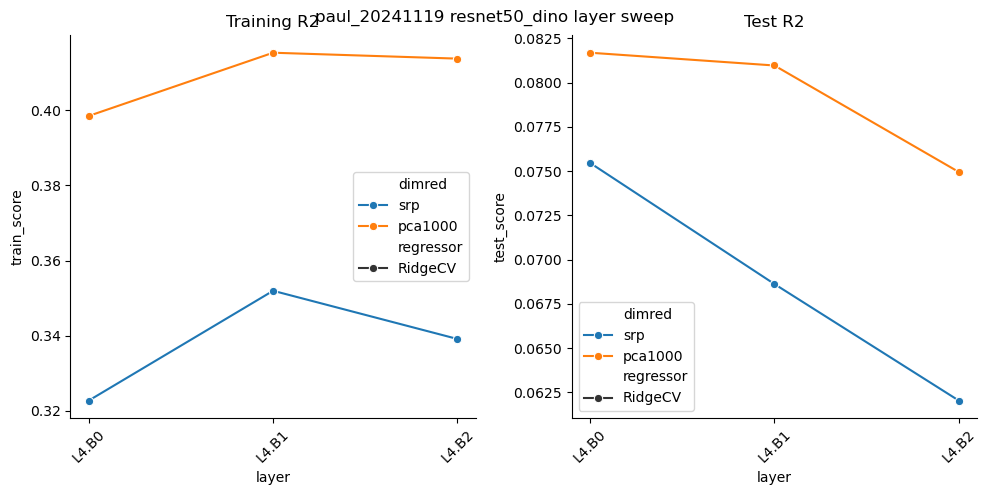

In [8]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "shared1000")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119.h5")
subject_id = 'paul_20241119' 
batch_size = 96 
device = "cuda" 
reliability_thresh = -1
data_dict = load_neural_data(data_path, subject_id, stimroot)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
figdir = join(dataroot, "model_outputs", subject_id, )
os.makedirs(figdir, exist_ok=True)
idx_train, idx_test = train_test_split(
    np.arange(len(resp_mat)), test_size=0.2, random_state=42, shuffle=True
)
# raise ValueError("stop here")
for modelname in ["resnet50_dino", ]: # "resnet50_robust", "resnet50", "resnet50_clip", 
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Load data
    # Prepare dataset
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)

    batch_size = 96
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    
    module_names = [name for name in fetcher.module_names.values() if "Bottleneck" in name and ("layer4" in name )] # or "layer3" in name
    print(module_names)
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()

    thresh = reliability_thresh
    chan_mask = reliability > thresh
    resp_mat_sel = resp_mat[:, chan_mask]
    print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
    result_df_lyrswp_RidgeCV, fit_models_lyrswp_RidgeCV, Xdict_lyrswp_RidgeCV, Xtfmer_lyrswp_RidgeCV = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, resp_mat_sel, 
                                                                            layer_names=module_names, dimred_list=["srp", "pca1000"], 
                                                                        alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                                                                        verbose=True)
    result_df_lyrswp_RidgeCV.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth")) 
    th.save(Xtfmer_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"))
    # for half the layers (later half) ~ 20 mins
    result_df_lyrswp_formatted = result_df_lyrswp_RidgeCV.reset_index()
    result_df_lyrswp_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
    result_df_lyrswp_formatted["layer"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[0])
    result_df_lyrswp_formatted["dimred"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])
    result_df_lyrswp_formatted.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV_formatted.csv"))


    figh, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(axs[0])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="train_score", style="regressor", hue="dimred", ax=axs[0], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Training R2")

    plt.sca(axs[1])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="test_score", style="regressor", hue="dimred", ax=axs[1], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Test R2")

    plt.tight_layout()
    plt.suptitle(f"{subject_id} {modelname} layer sweep")
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis")
    plt.show()

In [39]:
from sklearn.model_selection import train_test_split, GridSearchCV
def compute_D2_per_unit(rspavg_resp_peak, rspavg_pred):
    return 1 - np.square(rspavg_resp_peak - rspavg_pred).sum(axis=0) / np.square(rspavg_resp_peak - rspavg_resp_peak.mean(axis=0)).sum(axis=0)

idx_train, idx_test = train_test_split(
    np.arange(len(rspavg_resp_peak)), test_size=0.2, random_state=42, shuffle=True
)


Loading data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/vvs-accentuate-day1_normalize_paul_241119.h5
Fitting models for subject paul_20241119 with resnet50_robust model | 64 channels


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The (227, 227) setting is overwritten by the size in custom transform
['.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > None N=64
.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0_srp RidgeCV D2_train: 0.279 D2_test: 0.065
.layer4.Bottleneck0_pca1000 RidgeCV D2_train: 0.309 D2_test: 0.076
.layer4.Bottleneck1_srp RidgeCV D2_train: 0.256 D2_test: 0.069
.layer4.Bottleneck1_pca1000 RidgeCV D2_train: 0.299 D2_test: 0.077
.layer4.Bottleneck2_srp RidgeCV D2_train: 0.256 D2_test: 0.072
.layer4.Bottleneck2_pca1000 RidgeCV D2_train: 0.277 D2_test: 0.072
                                                                                 alpha  \
.layer4.Bottleneck0_srp     RidgeCV  [100000.0, 100000.0, 1000000000.0, 100000.0, 1...   
.layer4.Bottleneck0_pca1000 RidgeCV  [100000

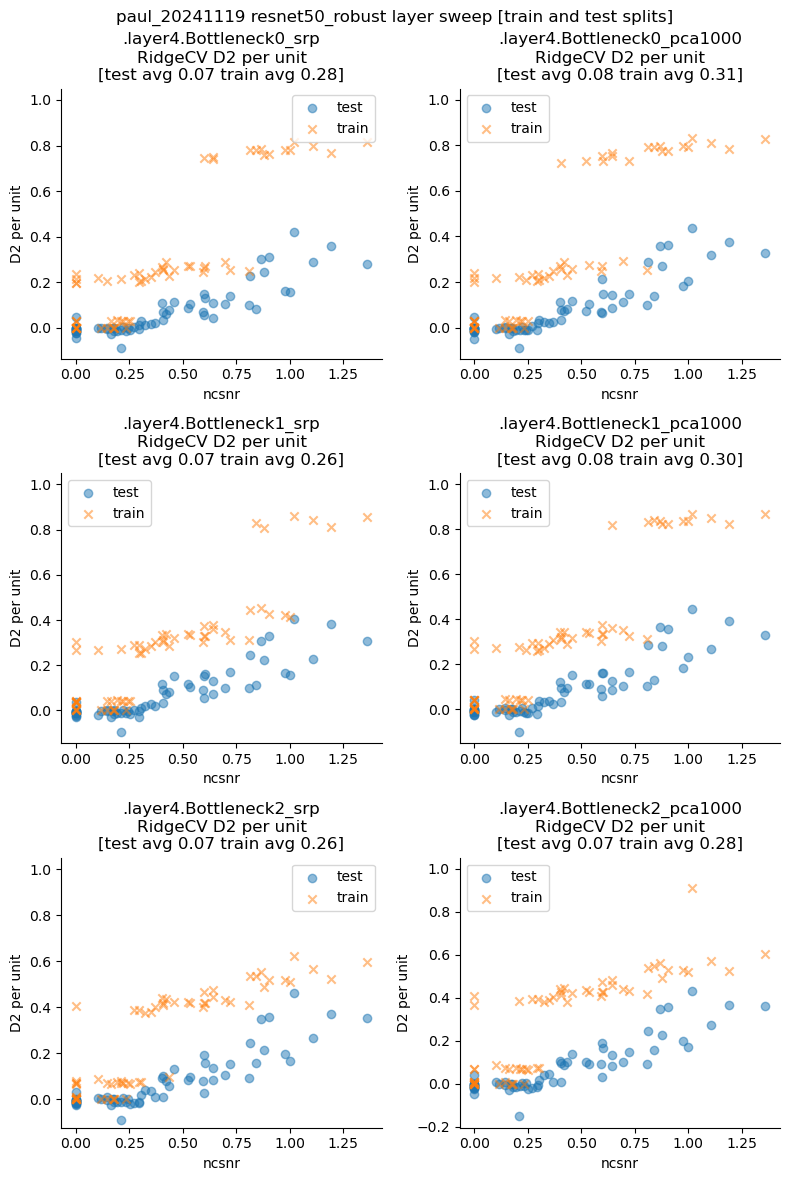

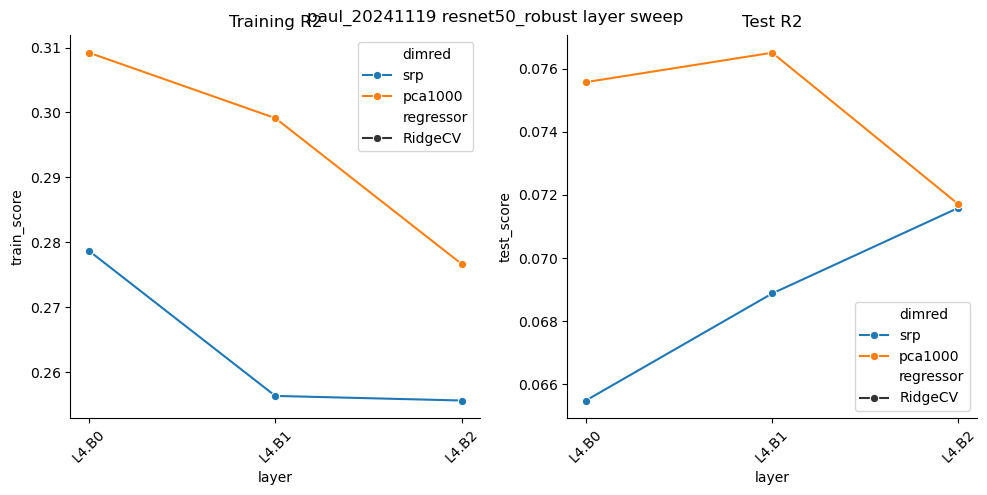

Fitting models for subject paul_20241119 with resnet50 model | 64 channels


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The (227, 227) setting is overwritten by the size in custom transform
['.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > None N=64
.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0_srp RidgeCV D2_train: 0.362 D2_test: 0.072
.layer4.Bottleneck0_pca1000 RidgeCV D2_train: 0.394 D2_test: 0.080
.layer4.Bottleneck1_srp RidgeCV D2_train: 0.284 D2_test: 0.067
.layer4.Bottleneck1_pca1000 RidgeCV D2_train: 0.359 D2_test: 0.068
.layer4.Bottleneck2_srp RidgeCV D2_train: 0.275 D2_test: 0.060
.layer4.Bottleneck2_pca1000 RidgeCV D2_train: 0.281 D2_test: 0.065
                                                                                 alpha  \
.layer4.Bottleneck0_srp     RidgeCV  [10000.0, 10000.0, 1000000000.0, 10000.0, 1000...   
.layer4.Bottleneck0_pca1000 RidgeCV  [10000.

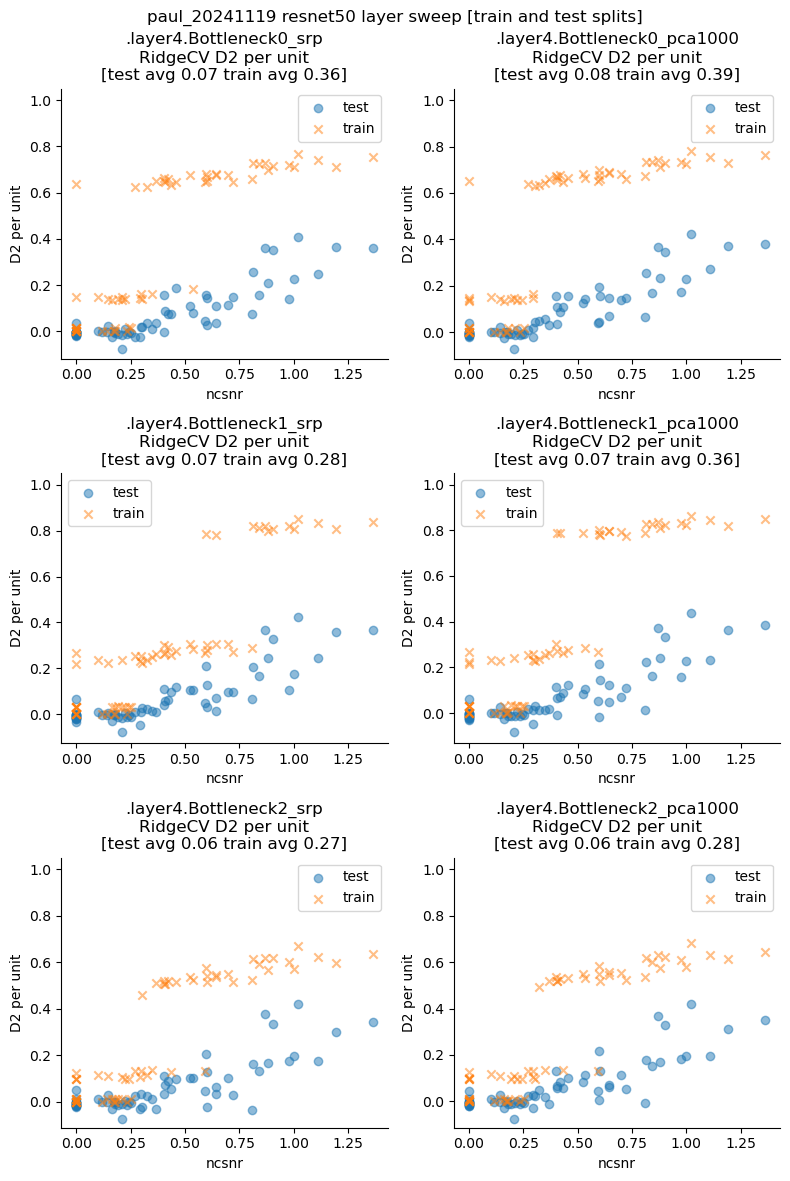

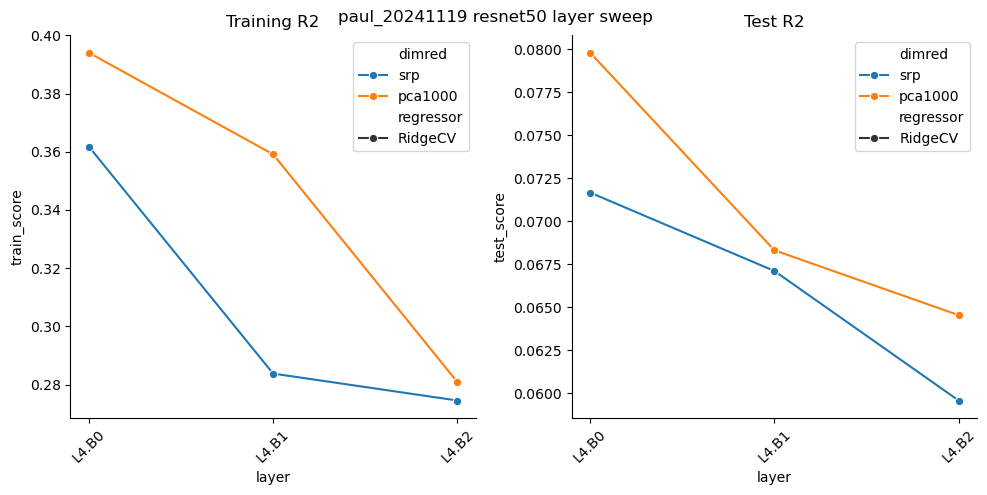

Fitting models for subject paul_20241119 with resnet50_clip model | 64 channels
The (227, 227) setting is overwritten by the size in custom transform
['.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > None N=64
.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0_srp RidgeCV D2_train: 0.326 D2_test: 0.074
.layer4.Bottleneck0_pca1000 RidgeCV D2_train: 0.389 D2_test: 0.080
.layer4.Bottleneck1_srp RidgeCV D2_train: 0.286 D2_test: 0.070
.layer4.Bottleneck1_pca1000 RidgeCV D2_train: 0.340 D2_test: 0.078
.layer4.Bottleneck2_srp RidgeCV D2_train: 0.288 D2_test: 0.072
.layer4.Bottleneck2_pca1000 RidgeCV D2_train: 0.319 D2_test: 0.074
                                                                                 alpha  \
.layer4.Bottleneck0_srp     RidgeCV  [100000.0, 100000.0, 1000000000.0, 100000.0, 1...   
.layer4.Bottleneck0_pca1000 RidgeCV  [100000

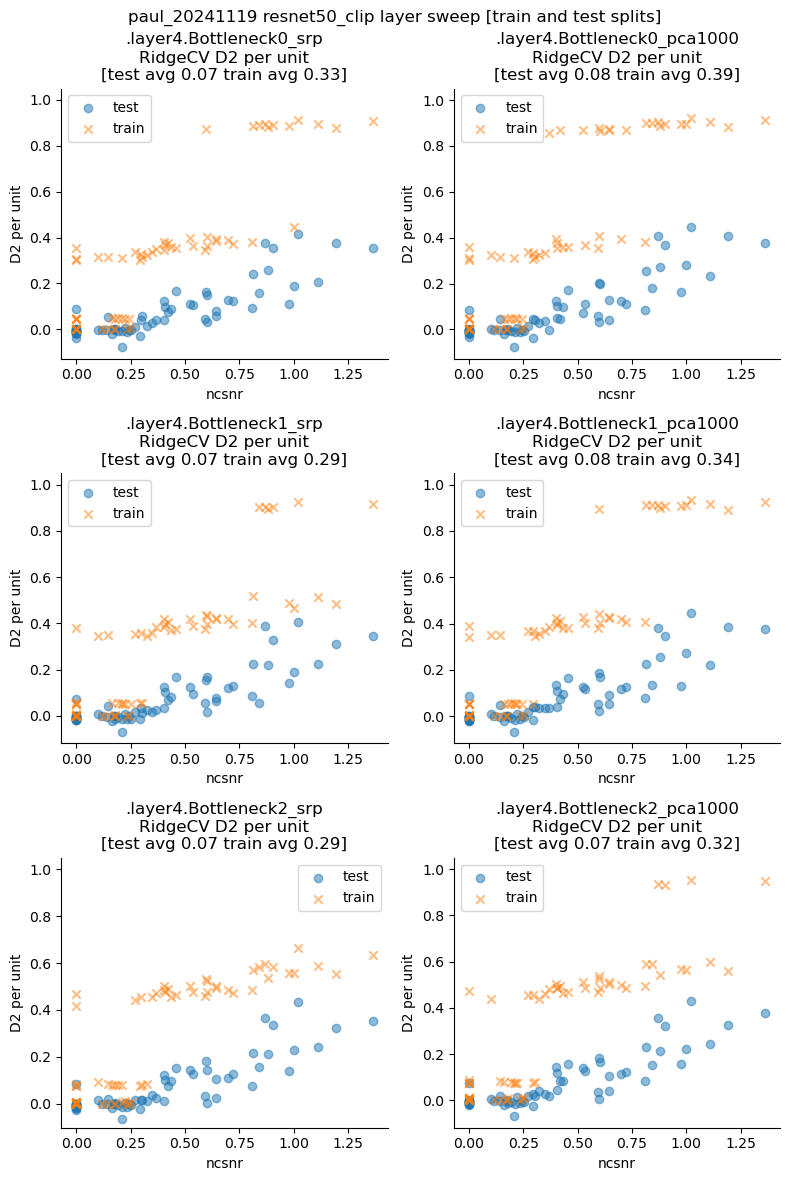

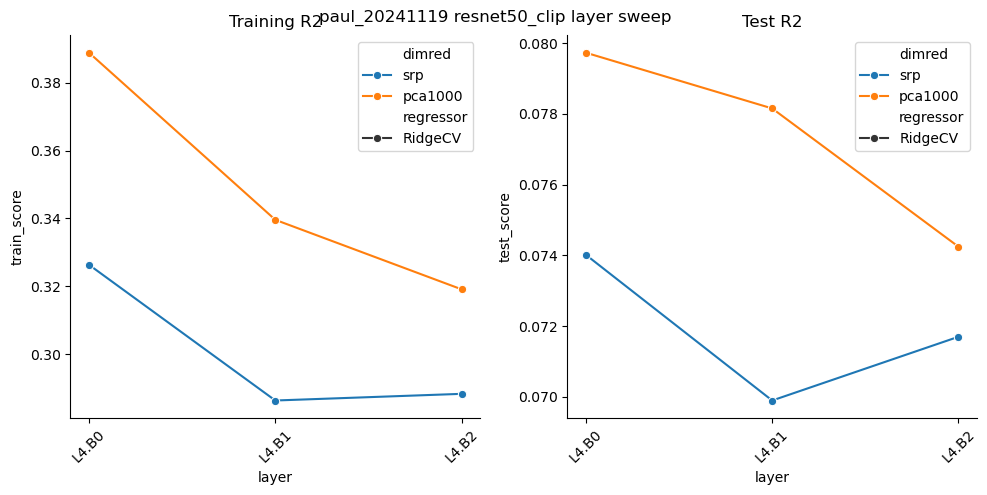

Fitting models for subject paul_20241119 with resnet50_dino model | 64 channels


Using cache found in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/torch_cache/hub/facebookresearch_dino_main
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The (227, 227) setting is overwritten by the size in custom transform
['.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > None N=64
.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0_srp RidgeCV D2_train: 0.323 D2_test: 0.075
.layer4.Bottleneck0_pca1000 RidgeCV D2_train: 0.398 D2_test: 0.082
.layer4.Bottleneck1_srp RidgeCV D2_train: 0.352 D2_test: 0.069
.layer4.Bottleneck1_pca1000 RidgeCV D2_train: 0.415 D2_test: 0.081
.layer4.Bottleneck2_srp RidgeCV D2_train: 0.339 D2_test: 0.062
.layer4.Bottleneck2_pca1000 RidgeCV D2_train: 0.414 D2_test: 0.075
                                                                                 alpha  \
.layer4.Bottleneck0_srp     RidgeCV  [100000.0, 100000.0, 10000000.0, 100000.0, 100...   
.layer4.Bottleneck0_pca1000 RidgeCV  [10000.

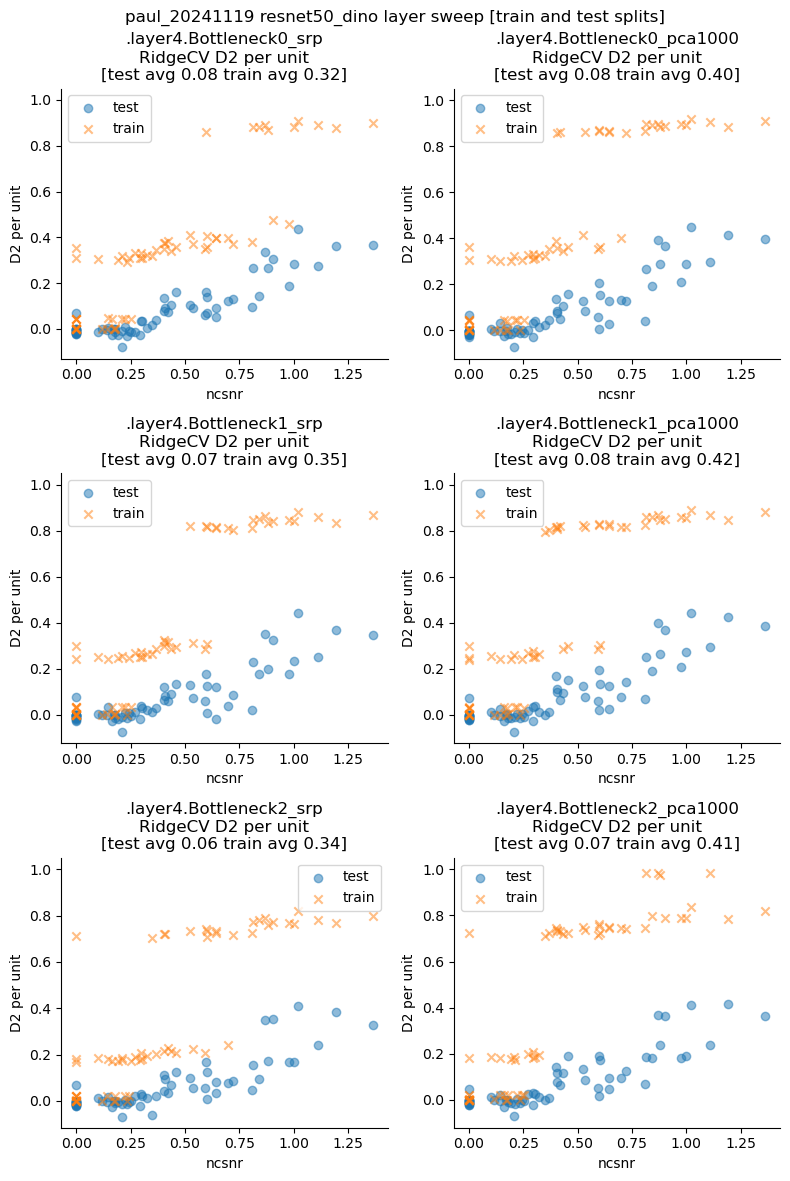

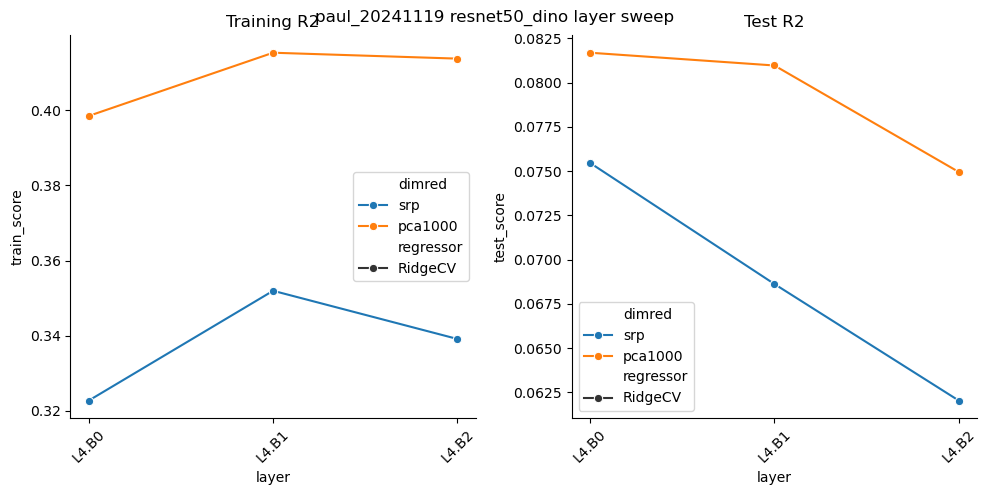

In [48]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "shared1000")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119.h5")
subject_id = 'paul_20241119' 
batch_size = 96 
device = "cuda" 
reliability_thresh = None
# Load data
data_dict = load_neural_data(data_path, subject_id, stimroot)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
print(f"Loading data from {data_path}")
figdir = join(dataroot, "model_outputs", subject_id, )
os.makedirs(figdir, exist_ok=True)
for modelname in ["resnet50_robust", "resnet50", "resnet50_clip", "resnet50_dino", ]: # 
    print(f"Fitting models for subject {subject_id} with {modelname} model | {len(ncsnr)} channels")
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)

    batch_size = 96
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    
    module_names = [name for name in fetcher.module_names.values() if "Bottleneck" in name and ("layer4" in name )] # or "layer3" in name
    print(module_names)
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()

    thresh = reliability_thresh
    if thresh is None:
        chan_mask = np.ones(len(ncsnr), dtype=bool)
    else:
        chan_mask = reliability > thresh
    resp_mat_sel = resp_mat[:, chan_mask]
    print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
    if os.path.exists(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl")):
        Xtfmer_lyrswp_RidgeCV = th.load(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"), )
    else:
        Xtfmer_lyrswp_RidgeCV = {}
    result_df_lyrswp_RidgeCV, fit_models_lyrswp_RidgeCV, Xdict_lyrswp_RidgeCV, Xtfmer_lyrswp_RidgeCV = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, resp_mat_sel, 
                                                                            layer_names=module_names, dimred_list=["srp", "pca1000"], 
                                                                        alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                                                                        verbose=True, pretrained_Xtransforms=Xtfmer_lyrswp_RidgeCV)
    result_df_lyrswp_RidgeCV.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth")) 
    th.save(Xtfmer_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"))
    
    # summarize prediction and evaluation
    pred_dict = {}
    D2_per_unit_train_dict = {}
    D2_per_unit_test_dict = {}
    D2_per_unit_dict = {}
    for (model_dimred, regressor) in fit_models_lyrswp_RidgeCV.keys():
        fit_model = fit_models_lyrswp_RidgeCV[(model_dimred, regressor)]
        Xfeat = Xdict_lyrswp_RidgeCV[(model_dimred)]
        # Xfeat_tfmer = Xtfmer_lyrswp_RidgeCV[(model_dimred)]
        rspavg_pred = fit_model.predict(Xfeat)
        pred_dict[(model_dimred, regressor)] = rspavg_pred
        D2_per_unit = compute_D2_per_unit(resp_mat_sel, rspavg_pred)
        D2_per_unit_train = compute_D2_per_unit(resp_mat_sel[idx_train], rspavg_pred[idx_train])
        D2_per_unit_test = compute_D2_per_unit(resp_mat_sel[idx_test], rspavg_pred[idx_test])
        D2_per_unit_train_dict[(model_dimred, regressor)] = D2_per_unit_train
        D2_per_unit_test_dict[(model_dimred, regressor)] = D2_per_unit_test

    pkl.dump({
        "pred_dict": pred_dict,
        "D2_per_unit_dict": D2_per_unit_dict,
        "D2_per_unit_train_dict": D2_per_unit_train_dict,
        "D2_per_unit_test_dict": D2_per_unit_test_dict,
    }, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))

    figh, axs = plt.subplots(3, 2, figsize=(8, 12))
    for (model_dimred, regressor), ax in zip(D2_per_unit_test_dict.keys(), axs.flatten()):
        plt.sca(ax)
        plt.scatter(ncsnr, D2_per_unit_test_dict[(model_dimred, regressor)], label="test", marker="o", alpha=0.5)
        plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="x", alpha=0.5)
        plt.ylim(None, 1.05)
        plt.xlabel("ncsnr")
        plt.legend()
        plt.ylabel("D2 per unit")
        plt.title(f"{model_dimred}\n{regressor} D2 per unit\n[test avg {D2_per_unit_test_dict[(model_dimred, regressor)].mean():.2f} train avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
    plt.suptitle(f"{subject_id} {modelname} layer sweep [train and test splits]")
    plt.tight_layout()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter")
    plt.show()
    
    
    # for half the layers (later half) ~ 20 mins
    result_df_lyrswp_formatted = result_df_lyrswp_RidgeCV.reset_index()
    result_df_lyrswp_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
    result_df_lyrswp_formatted["layer"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[0])
    result_df_lyrswp_formatted["dimred"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])
    result_df_lyrswp_formatted.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV_formatted.csv"))


    figh, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(axs[0])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="train_score", style="regressor", hue="dimred", ax=axs[0], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Training R2")

    plt.sca(axs[1])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="test_score", style="regressor", hue="dimred", ax=axs[1], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Test R2")

    plt.tight_layout()
    plt.suptitle(f"{subject_id} {modelname} layer sweep")
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis")
    plt.show()

### Neural pixel array fitting

In [49]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "shared1000")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119.h5")
subject_id = 'paul_241119'
batch_size = 96 
device = "cuda" 
reliability_thresh = None
# Load data
data_dict = load_neural_data(data_path, subject_id, stimroot)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
print(f"Loading data from {data_path}")
figdir = join(dataroot, "model_outputs", subject_id, )
os.makedirs(figdir, exist_ok=True)
idx_train, idx_test = train_test_split(
    np.arange(len(resp_mat)), test_size=0.2, random_state=42, shuffle=True
)
for modelname in ["resnet50_robust", "resnet50", "resnet50_clip", "resnet50_dino", ]: # 
    print(f"Fitting models for subject {subject_id} with {modelname} model | {len(ncsnr)} channels")
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)

    batch_size = 96
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    
    module_names = [name for name in fetcher.module_names.values() if "Bottleneck" in name and ("layer4" in name )] # or "layer3" in name
    print(module_names)
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()

    thresh = reliability_thresh
    if thresh is None:
        chan_mask = np.ones(len(ncsnr), dtype=bool)
    else:
        chan_mask = reliability > thresh
    resp_mat_sel = resp_mat[:, chan_mask]
    print(f"Fitting models for reliable channels > {thresh} N={chan_mask.sum()}")
    if os.path.exists(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl")):
        Xtfmer_lyrswp_RidgeCV = th.load(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"), )
    else:
        Xtfmer_lyrswp_RidgeCV = {}
    result_df_lyrswp_RidgeCV, fit_models_lyrswp_RidgeCV, Xdict_lyrswp_RidgeCV, Xtfmer_lyrswp_RidgeCV = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, resp_mat_sel, 
                                                                            layer_names=module_names, dimred_list=["srp", "pca1000"], 
                                                                        alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                                                                        verbose=True, pretrained_Xtransforms=Xtfmer_lyrswp_RidgeCV)
    result_df_lyrswp_RidgeCV.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth")) 
    th.save(Xtfmer_lyrswp_RidgeCV, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"))
    
    # summarize prediction and evaluation
    pred_dict = {}
    D2_per_unit_train_dict = {}
    D2_per_unit_test_dict = {}
    D2_per_unit_dict = {}
    for (model_dimred, regressor) in fit_models_lyrswp_RidgeCV.keys():
        fit_model = fit_models_lyrswp_RidgeCV[(model_dimred, regressor)]
        Xfeat = Xdict_lyrswp_RidgeCV[(model_dimred)]
        # Xfeat_tfmer = Xtfmer_lyrswp_RidgeCV[(model_dimred)]
        rspavg_pred = fit_model.predict(Xfeat)
        pred_dict[(model_dimred, regressor)] = rspavg_pred
        D2_per_unit = compute_D2_per_unit(resp_mat_sel, rspavg_pred)
        D2_per_unit_train = compute_D2_per_unit(resp_mat_sel[idx_train], rspavg_pred[idx_train])
        D2_per_unit_test = compute_D2_per_unit(resp_mat_sel[idx_test], rspavg_pred[idx_test])
        D2_per_unit_train_dict[(model_dimred, regressor)] = D2_per_unit_train
        D2_per_unit_test_dict[(model_dimred, regressor)] = D2_per_unit_test

    pkl.dump({
        "pred_dict": pred_dict,
        "D2_per_unit_dict": D2_per_unit_dict,
        "D2_per_unit_train_dict": D2_per_unit_train_dict,
        "D2_per_unit_test_dict": D2_per_unit_test_dict,
    }, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))

    figh, axs = plt.subplots(3, 2, figsize=(8, 12))
    for (model_dimred, regressor), ax in zip(D2_per_unit_test_dict.keys(), axs.flatten()):
        plt.sca(ax)
        plt.scatter(ncsnr, D2_per_unit_test_dict[(model_dimred, regressor)], label="test", marker="o", alpha=0.5)
        plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="x", alpha=0.5)
        plt.ylim(None, 1.05)
        plt.xlabel("ncsnr")
        plt.legend()
        plt.ylabel("D2 per unit")
        plt.title(f"{model_dimred}\n{regressor} D2 per unit\n[test avg {D2_per_unit_test_dict[(model_dimred, regressor)].mean():.2f} train avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
    plt.suptitle(f"{subject_id} {modelname} layer sweep [train and test splits]")
    plt.tight_layout()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter")
    plt.show()
    
    
    # for half the layers (later half) ~ 20 mins
    result_df_lyrswp_formatted = result_df_lyrswp_RidgeCV.reset_index()
    result_df_lyrswp_formatted.rename(columns={"level_0": "layer_dimred", "level_1": "regressor", }, inplace=True)
    result_df_lyrswp_formatted["layer"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[0])
    result_df_lyrswp_formatted["dimred"] = result_df_lyrswp_formatted["layer_dimred"].apply(lambda x: x.split("_")[-1])
    result_df_lyrswp_formatted.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV_formatted.csv"))


    figh, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(axs[0])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="train_score", style="regressor", hue="dimred", ax=axs[0], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Training R2")

    plt.sca(axs[1])
    sns.lineplot(data=result_df_lyrswp_formatted, x="layer", 
            y="test_score", style="regressor", hue="dimred", ax=axs[1], marker="o")
    plt.xticks(rotation=45)
    xticklabels = plt.gca().get_xticklabels()
    xticklabels = [label.get_text().replace("Bottleneck", "B").replace(".layer", "L") for label in xticklabels]
    plt.xticks(ticks=range(len(xticklabels)), labels=xticklabels, rotation=45)
    plt.title("Test R2")

    plt.tight_layout()
    plt.suptitle(f"{subject_id} {modelname} layer sweep")
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis")
    plt.show()

Loading data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/vvs-accentuate-day1_normalize_paul_241119.h5
Fitting models for subject paul_241119 with resnet50_robust model | 383 channels


/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The (227, 227) setting is overwritten by the size in custom transform
['.layer4.Bottleneck0', '.layer4.Bottleneck1', '.layer4.Bottleneck2']


  0%|          | 0/11 [00:00<?, ?it/s]

.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
FeatureFetcher hooks all freed
Fitting models for reliable channels > None N=383
.layer4.Bottleneck0 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck1 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck2 torch.Size([1028, 2048, 7, 7])
.layer4.Bottleneck0_srp RidgeCV D2_train: 0.075 D2_test: 0.001
.layer4.Bottleneck0_pca1000 RidgeCV D2_train: 0.080 D2_test: 0.002
.layer4.Bottleneck1_srp RidgeCV D2_train: 0.072 D2_test: 0.001
.layer4.Bottleneck1_pca1000 RidgeCV D2_train: 0.076 D2_test: 0.001
.layer4.Bottleneck2_srp RidgeCV D2_train: 0.065 D2_test: 0.001
.layer4.Bottleneck2_pca1000 RidgeCV D2_train: 0.068 D2_test: 0.001
                                                                                 alpha  \
.layer4.Bottleneck0_srp     RidgeCV  [1000000000.0, 1000000000.0, 1000000.0, 100000...   
.layer4.Bottleneck0_pca1000 RidgeCV  [10000

ValueError: operands could not be broadcast together with shapes (1028,64) (1028,383) 

### Evaluate the fits separately

In [44]:
rspavg_pred

array([[0.46502571, 0.530665  , 0.48078774, ..., 0.63191901, 0.29132967,
        0.49452008],
       [0.57262446, 0.47385085, 0.47955196, ..., 0.54764787, 0.3751547 ,
        0.51015929],
       [0.60387989, 0.66790043, 0.48071936, ..., 0.53858882, 0.40156122,
        0.49245193],
       ...,
       [1.62651854, 0.84501692, 0.47962383, ..., 0.41660494, 0.6354187 ,
        0.5789594 ],
       [1.66385962, 1.25584118, 0.48505274, ..., 0.3926906 , 0.7912529 ,
        0.55886755],
       [2.2149652 , 0.99234585, 0.49847044, ..., 0.45830786, 0.69148003,
        0.51728337]])

In [31]:
pred_dict = {}
D2_per_unit_train_dict = {}
D2_per_unit_test_dict = {}
for (model_dimred, regressor) in fit_models_lyrswp_RidgeCV.keys():
    fit_model = fit_models_lyrswp_RidgeCV[(model_dimred, regressor)]
    Xfeat = Xdict_lyrswp_RidgeCV[(model_dimred)]
    # Xfeat_tfmer = Xtfmer_lyrswp_RidgeCV[(model_dimred)]
    rspavg_pred = fit_model.predict(Xfeat)
    pred_dict[(model_dimred, regressor)] = rspavg_pred
    D2_per_unit_train = compute_D2_per_unit(rspavg_resp_peak[idx_train], rspavg_pred[idx_train])
    D2_per_unit_test = compute_D2_per_unit(rspavg_resp_peak[idx_test], rspavg_pred[idx_test])
    D2_per_unit_train_dict[(model_dimred, regressor)] = D2_per_unit_train
    D2_per_unit_test_dict[(model_dimred, regressor)] = D2_per_unit_test

pkl.dump({
    "pred_dict": pred_dict,
    "D2_per_unit_train_dict": D2_per_unit_train_dict,
    "D2_per_unit_test_dict": D2_per_unit_test_dict,
}, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))

figh, axs = plt.subplots(3, 2, figsize=(8, 12))
for (model_dimred, regressor), ax in zip(D2_per_unit_test_dict.keys(), axs.flatten()):
    plt.sca(ax)
    plt.scatter(ncsnr, D2_per_unit_test_dict[(model_dimred, regressor)], label="test", marker="o", alpha=0.5)
    plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="x", alpha=0.5)
    plt.ylim(None, 1.05)
    plt.xlabel("ncsnr")
    plt.legend()
    plt.ylabel("D2 per unit")
    plt.title(f"{model_dimred}\n{regressor} D2 per unit\n[test avg {D2_per_unit_test_dict[(model_dimred, regressor)].mean():.2f} train avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
plt.suptitle(f"{subject_id} {modelname} layer sweep [train and test splits]")
plt.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter")
plt.show()

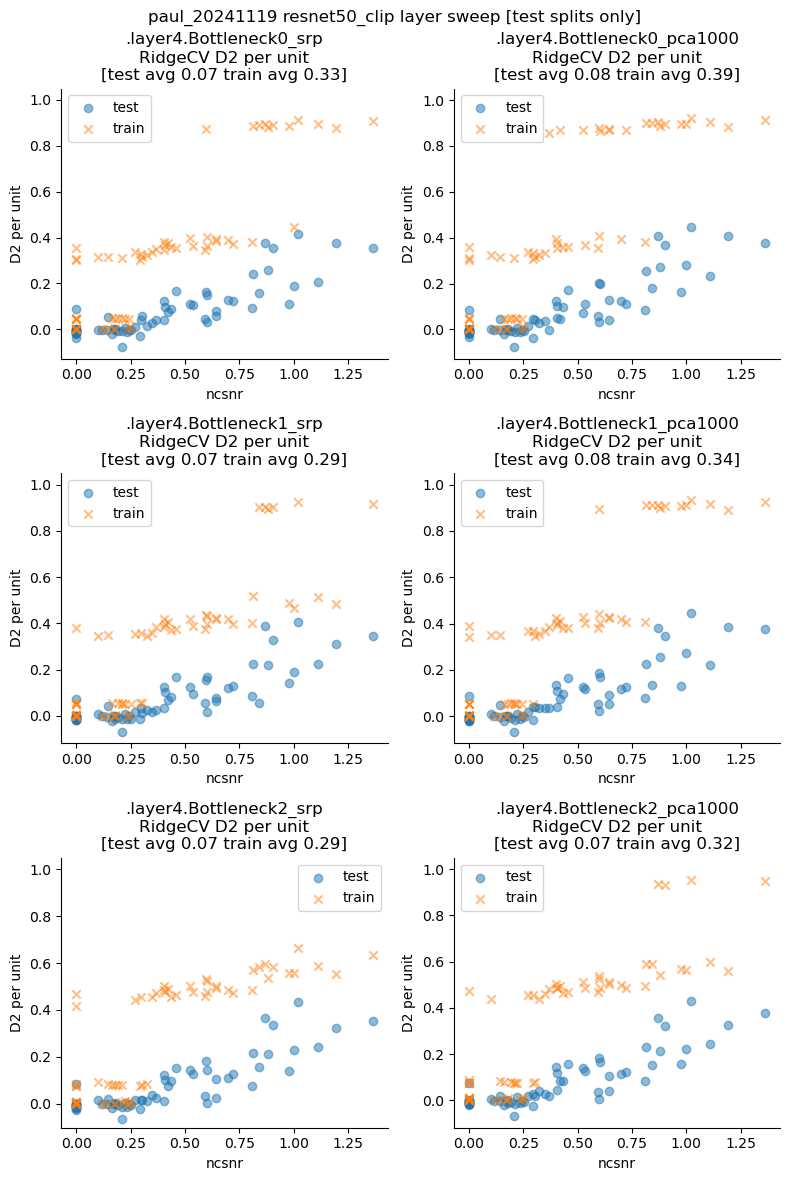

In [42]:
figh, axs = plt.subplots(3, 2, figsize=(8, 12))
for (model_dimred, regressor), ax in zip(D2_per_unit_test_dict.keys(), axs.flatten()):
    plt.sca(ax)
    plt.scatter(ncsnr, D2_per_unit_test_dict[(model_dimred, regressor)], label="test", marker="o", alpha=0.5)
    plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="x", alpha=0.5)
    plt.ylim(None, 1.05)
    plt.xlabel("ncsnr")
    plt.legend()
    plt.ylabel("D2 per unit")
    plt.title(f"{model_dimred}\n{regressor} D2 per unit\n[test avg {D2_per_unit_test_dict[(model_dimred, regressor)].mean():.2f} train avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
plt.suptitle(f"{subject_id} {modelname} layer sweep [test splits only]")
plt.tight_layout()
plt.show()

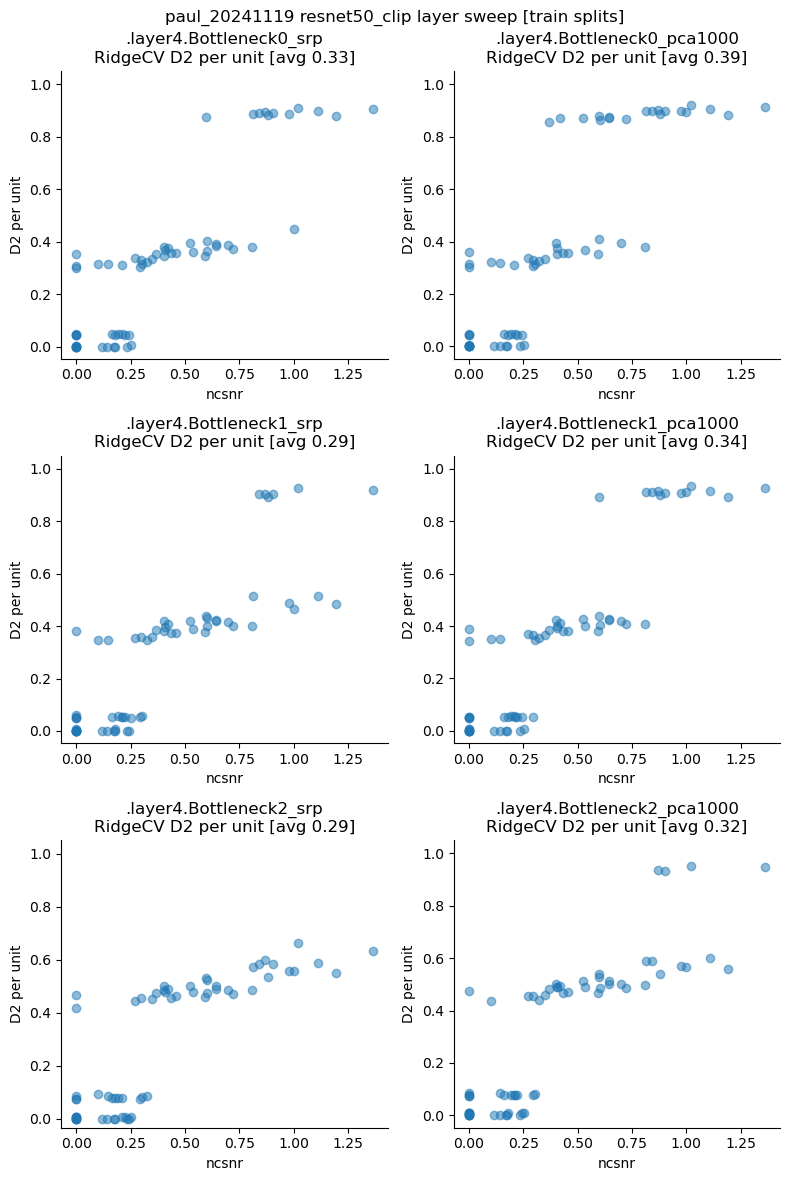

In [38]:
figh, axs = plt.subplots(3, 2, figsize=(8, 12))
for (model_dimred, regressor), ax in zip(D2_per_unit_train_dict.keys(), axs.flatten()):
    plt.sca(ax)
    plt.scatter(ncsnr, D2_per_unit_train_dict[(model_dimred, regressor)], label="train", marker="o", alpha=0.5)
    plt.ylim(None, 1.05)
    plt.xlabel("ncsnr")
    plt.ylabel("D2 per unit")
    plt.title(f"{model_dimred}\n{regressor} D2 per unit [avg {D2_per_unit_train_dict[(model_dimred, regressor)].mean():.2f}]")
plt.suptitle(f"{subject_id} {modelname} layer sweep [train splits]")
plt.tight_layout()
plt.show()

In [ ]:
# !cd /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation
!for file in /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/stimuli_pilot_20241119/results/*; do
    ln -sf "$file" shared1000
done

In [6]:
data_dict

{'brain_area': array([b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT',
        b'l_cIT', b'l_cIT', b'l_cIT', b'l_cIT'], dtype=object),
 'ncsnr': array([0.8082842 , 0.5987334 , 0.        , 0.7216381 , 0.14398432,
        0.8402192 , 0.9996467 , 1.1090726 , 0.86786723, 0.5246871 ,
        0.25285387, 0.40623817, 0.11611781, 0.3684164 , 0.29429722,
        0.593332  , 0.2720084